In [4]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pymc3 as pm

import patch
import kinematics

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [6]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [7]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [8]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [9]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Time in Patch: Simple Linear Regression

ShortSession0


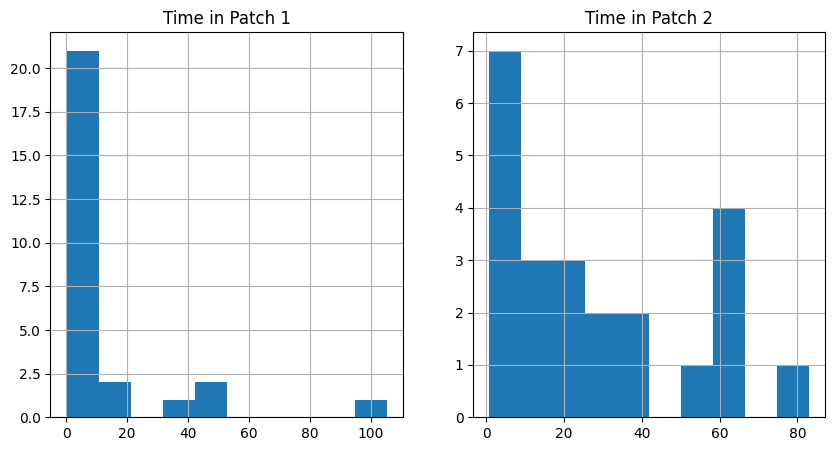

MSE: 497.22992594521014, R-squared: 0.014078196456267067
MSE: 547.0059166645576, R-squared: 0.05357632295522985


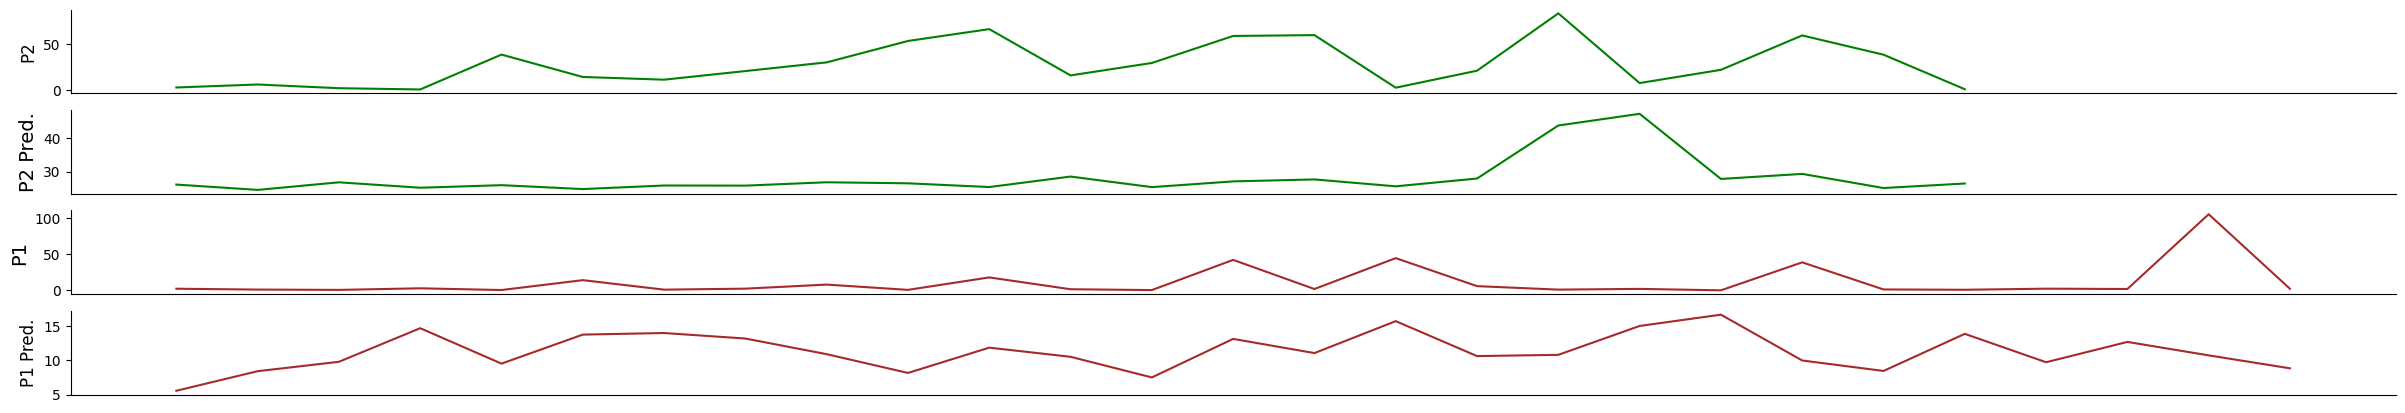

ShortSession1


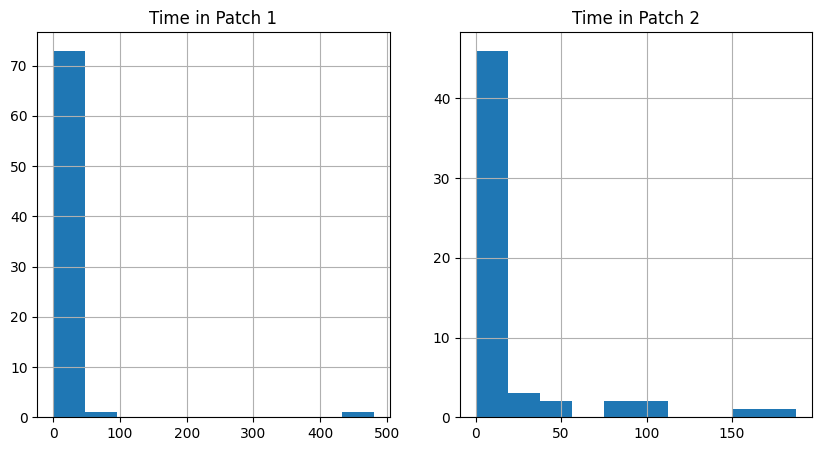

MSE: 2850.5789780192167, R-squared: 0.08549456333582606
MSE: 1170.2493579087268, R-squared: 0.20050018033992634


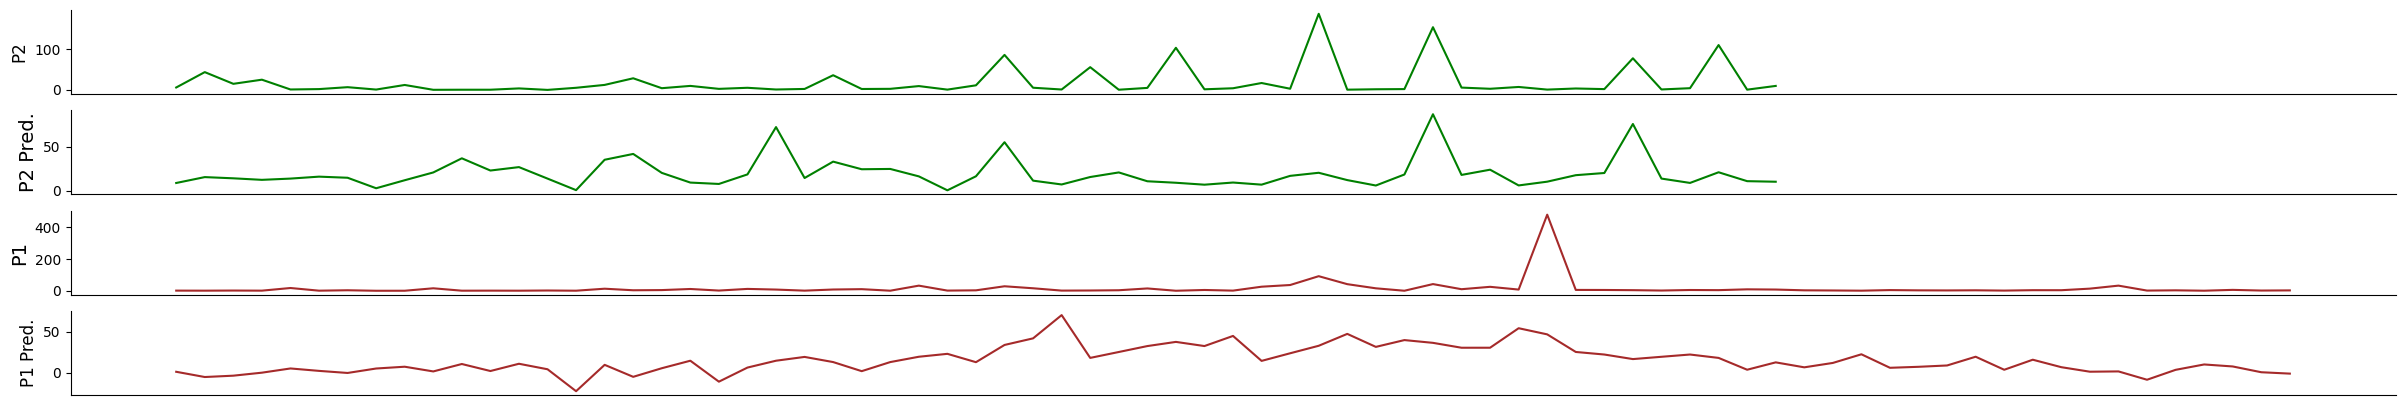

ShortSession2


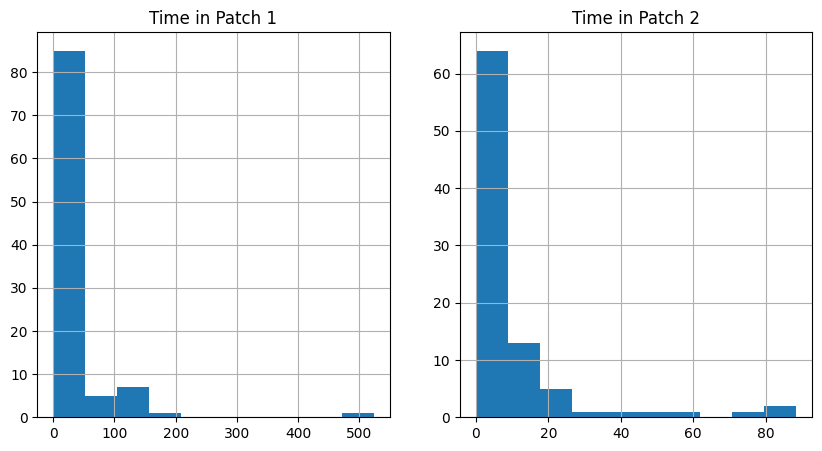

MSE: 3743.5711429334538, R-squared: 0.05781163943405354
MSE: 274.73499616660325, R-squared: 0.02887772831720159


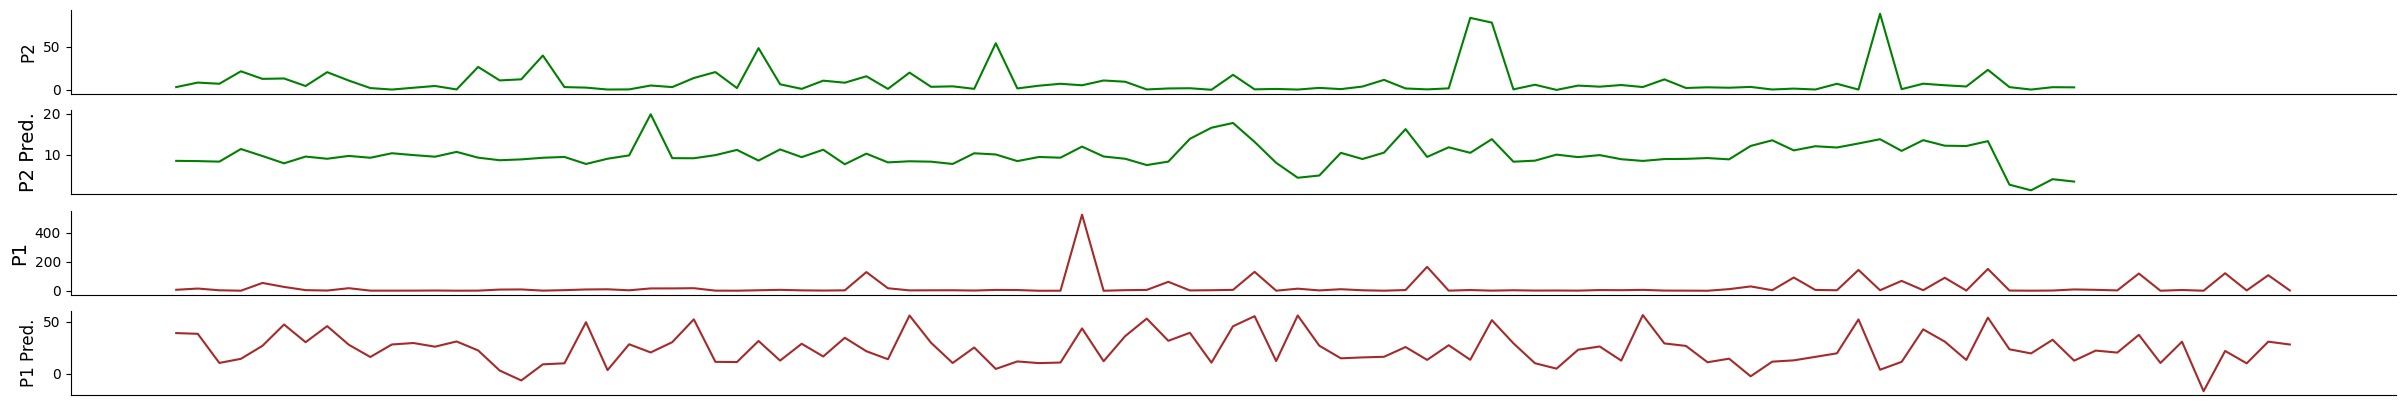

ShortSession3


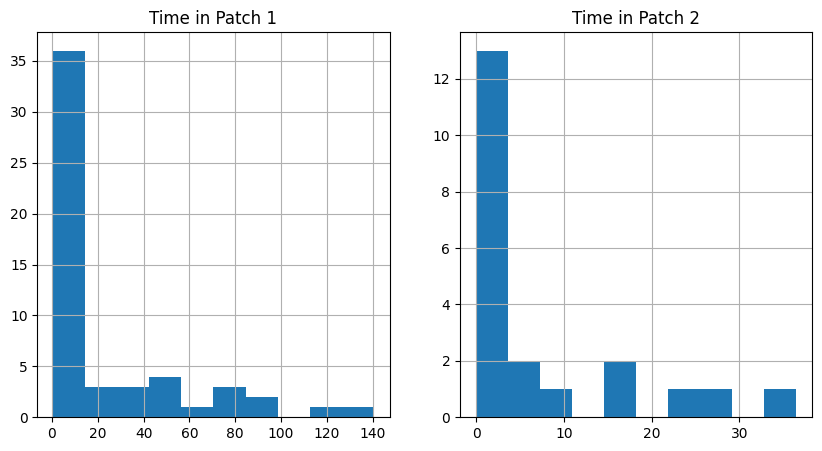

MSE: 992.5086839130212, R-squared: 0.08647094423669432
MSE: 73.469078747064, R-squared: 0.29338067768613396


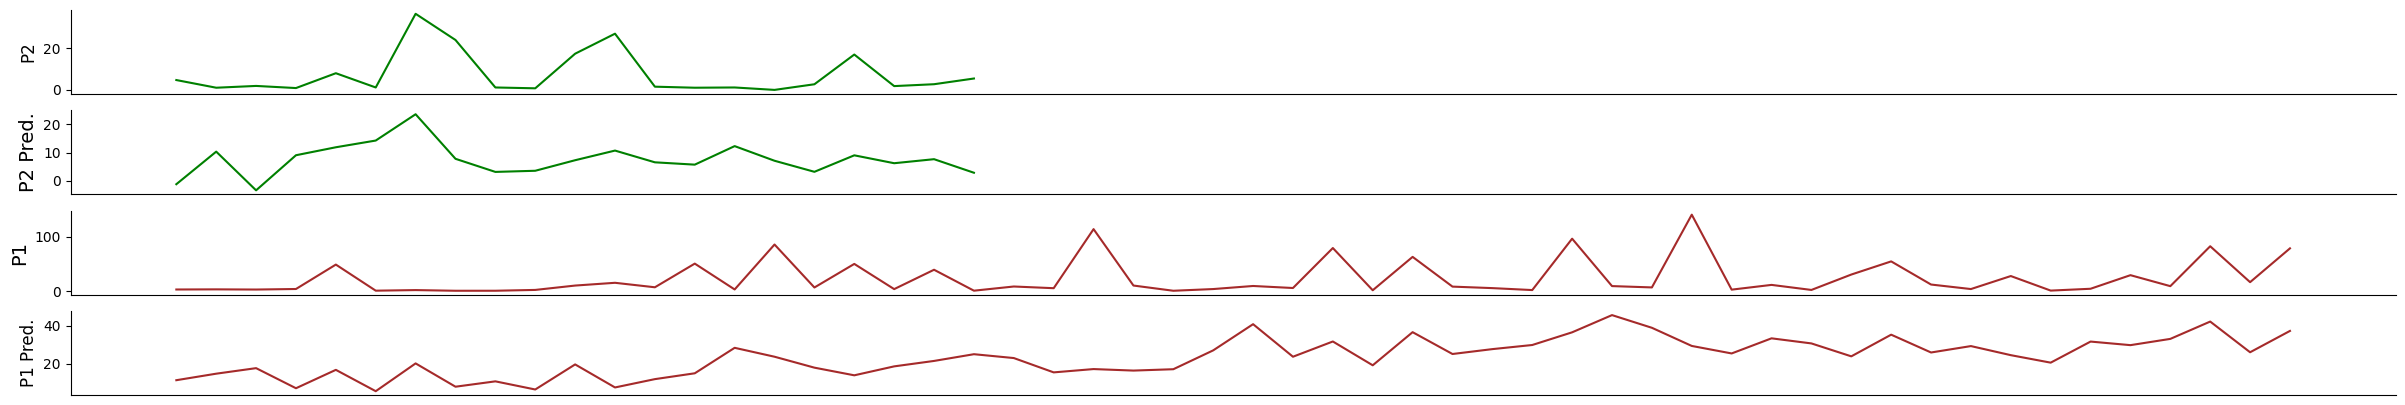

ShortSession4


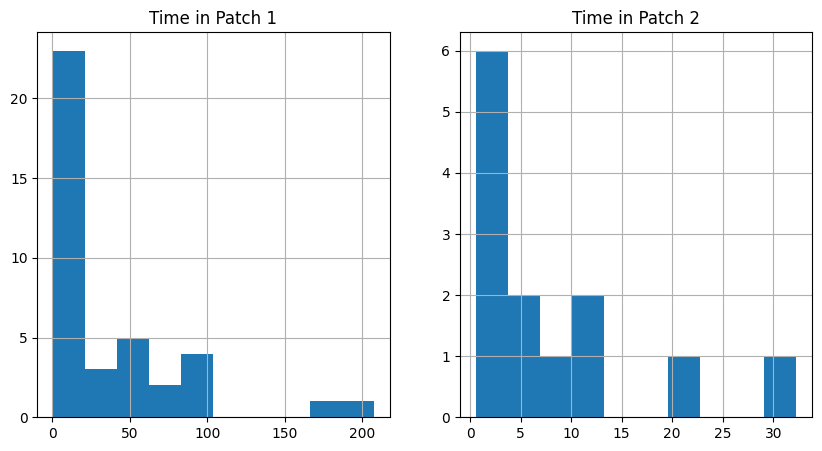

MSE: 1759.215991256779, R-squared: 0.24989618352927745
MSE: 63.33294903713622, R-squared: 0.2044539552402811


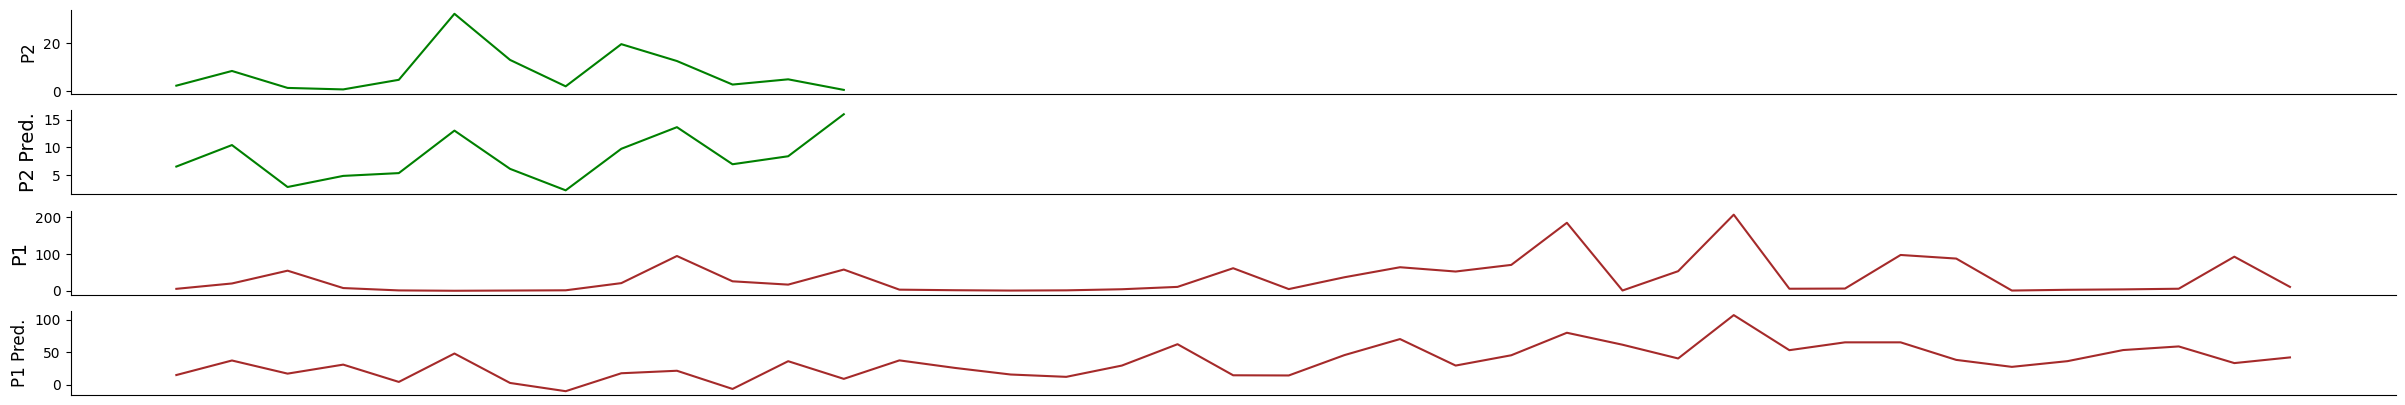

ShortSession5


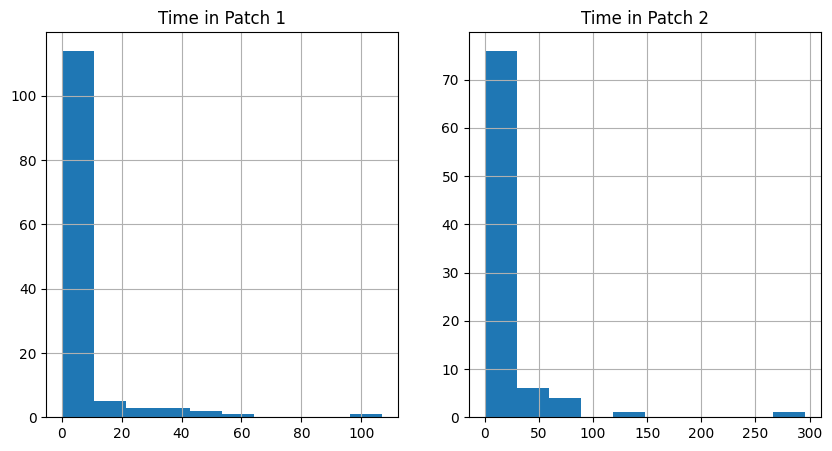

MSE: 174.94649238927022, R-squared: 0.015770860997266767
MSE: 1345.7584091546612, R-squared: 0.012907157052164275


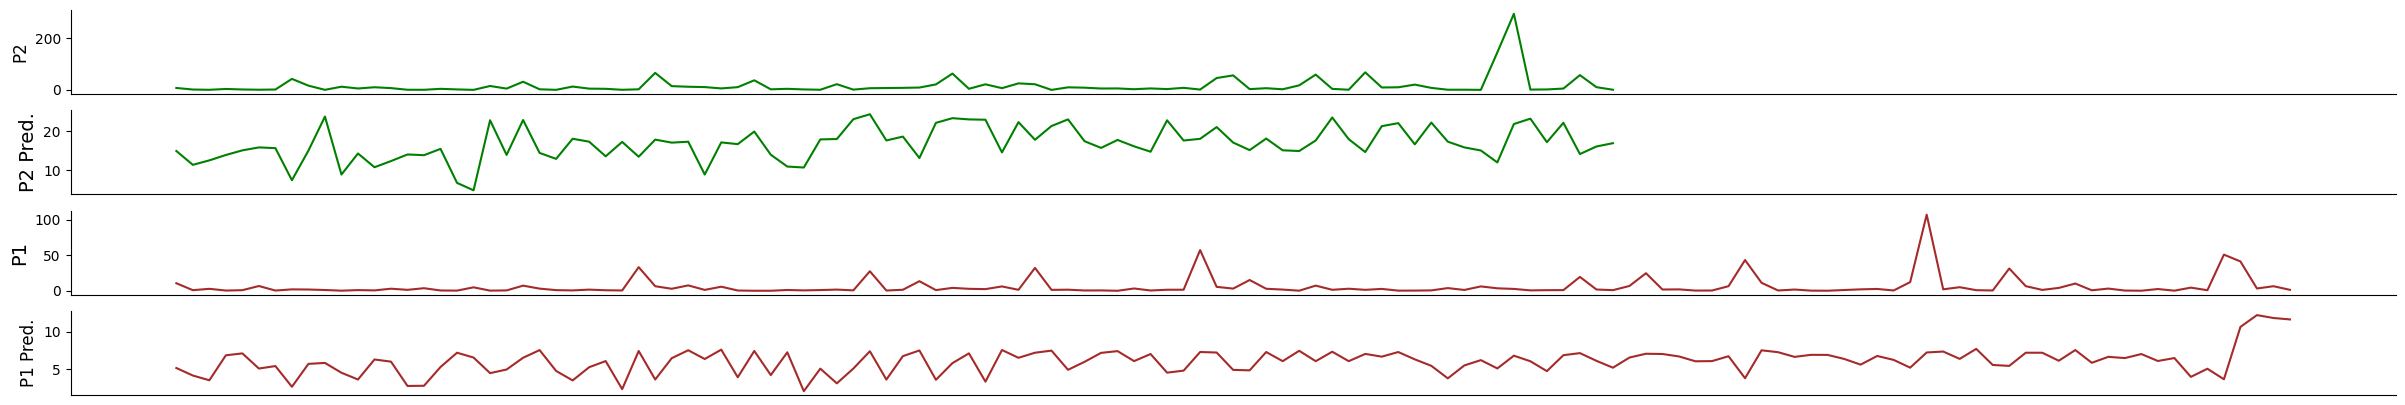

ShortSession6


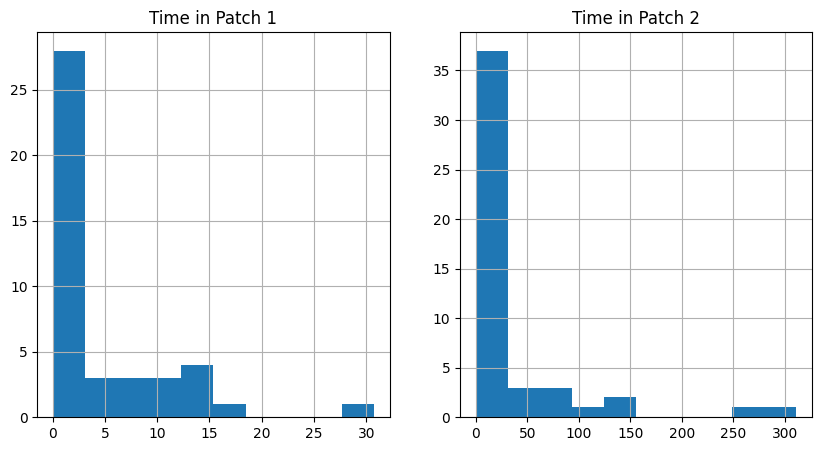

MSE: 39.944466101877815, R-squared: 0.033781108360965595
MSE: 3875.557566261464, R-squared: 0.02375909484164196


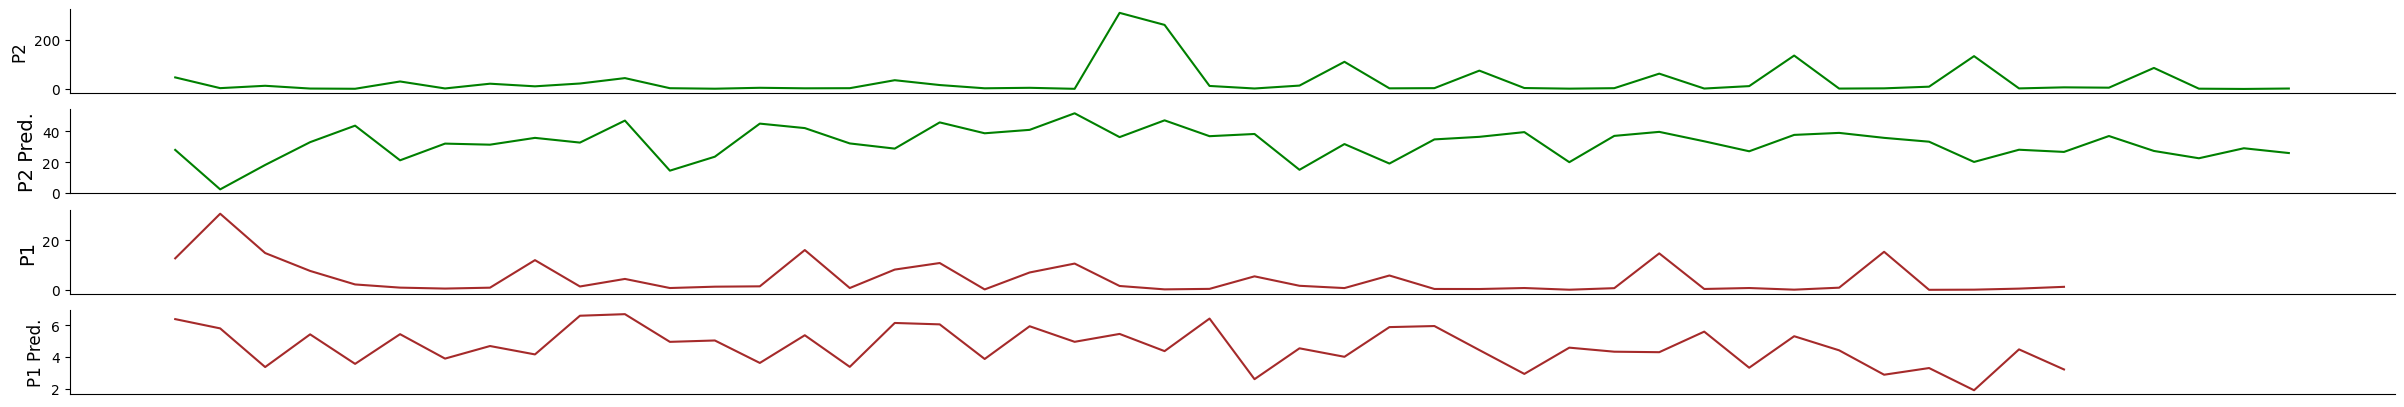

ShortSession7


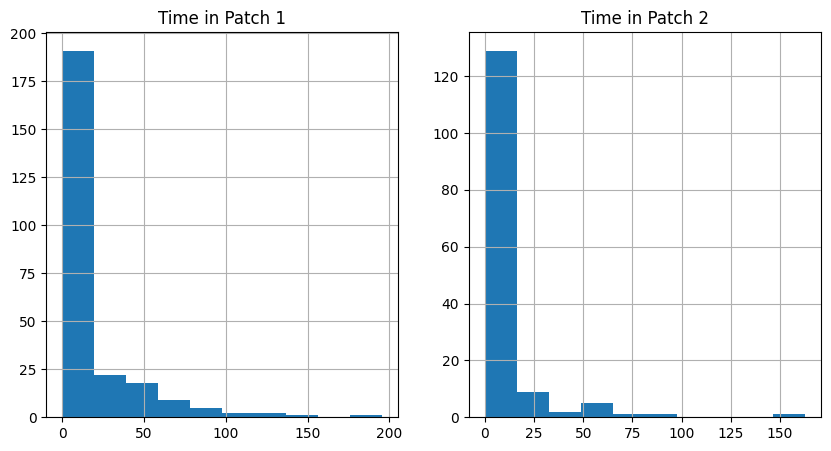

MSE: 758.4030868245761, R-squared: 0.05114126052557977
MSE: 369.54185059775244, R-squared: 0.016146627550644554


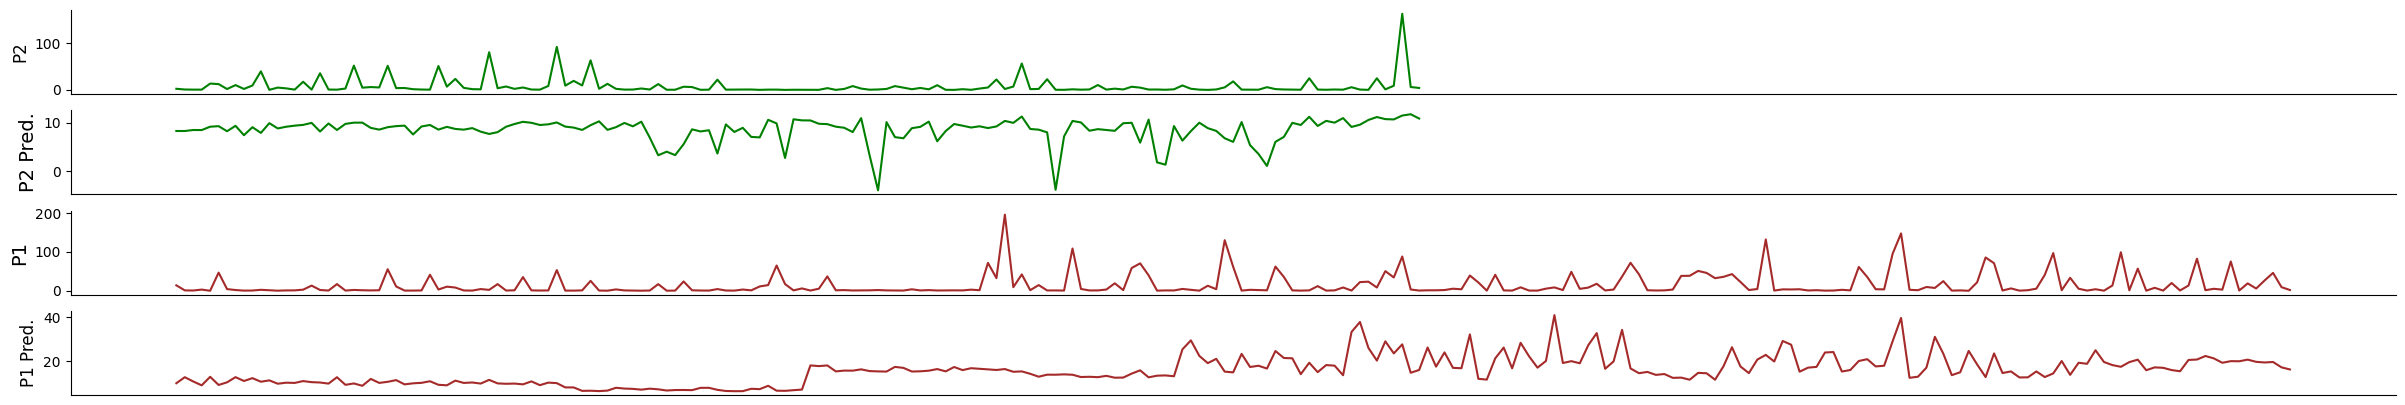

ShortSession8


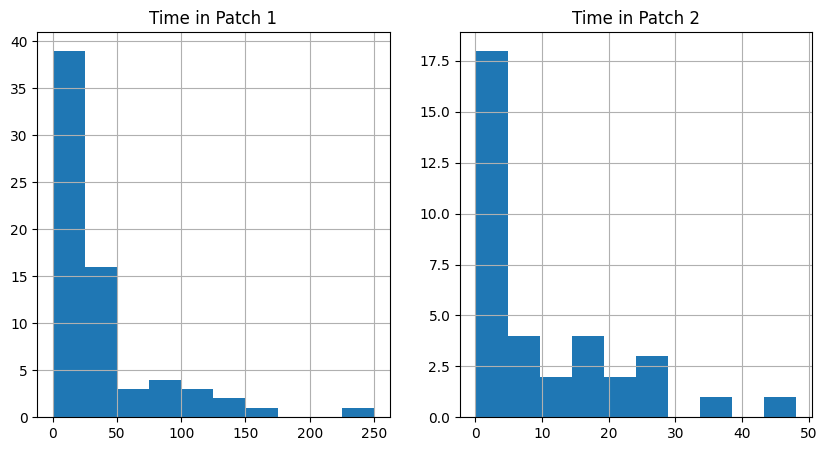

MSE: 1771.563517480278, R-squared: 0.1260190970155789
MSE: 138.03287239647096, R-squared: 0.037206303442202104


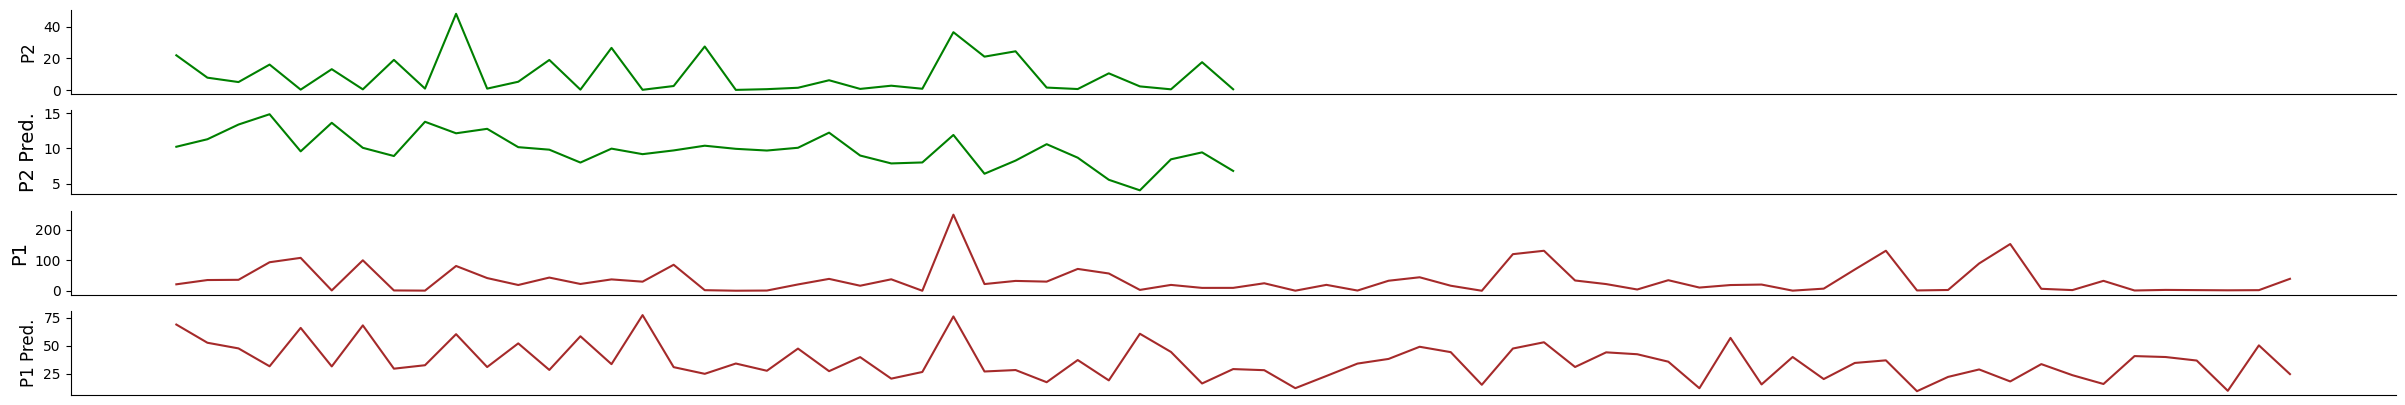

ShortSession9


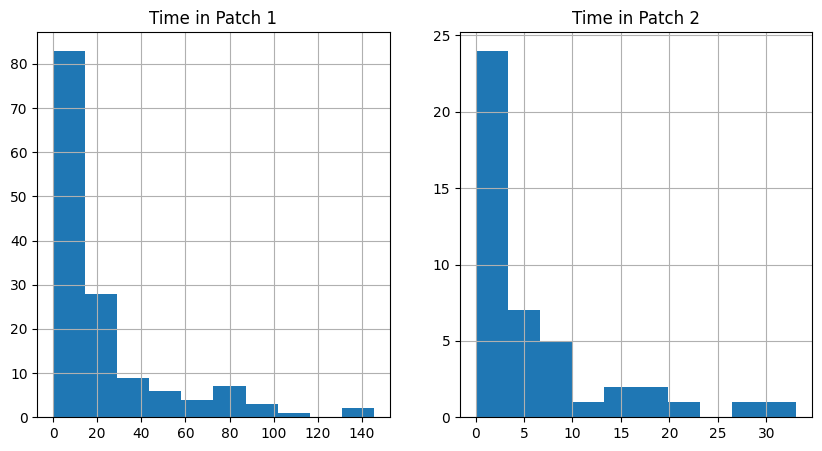

MSE: 684.4475224369667, R-squared: 0.14079593439302074
MSE: 54.673099785381446, R-squared: 0.09052249301628834


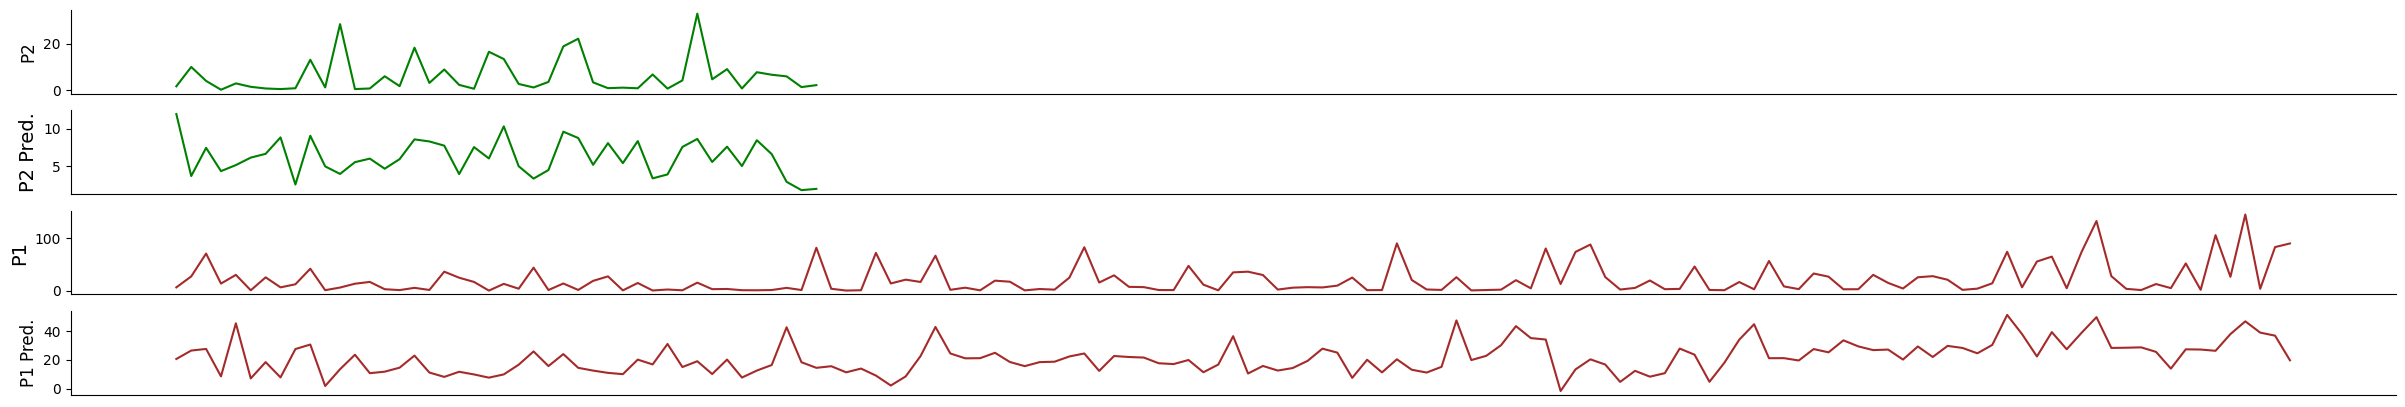

ShortSession10


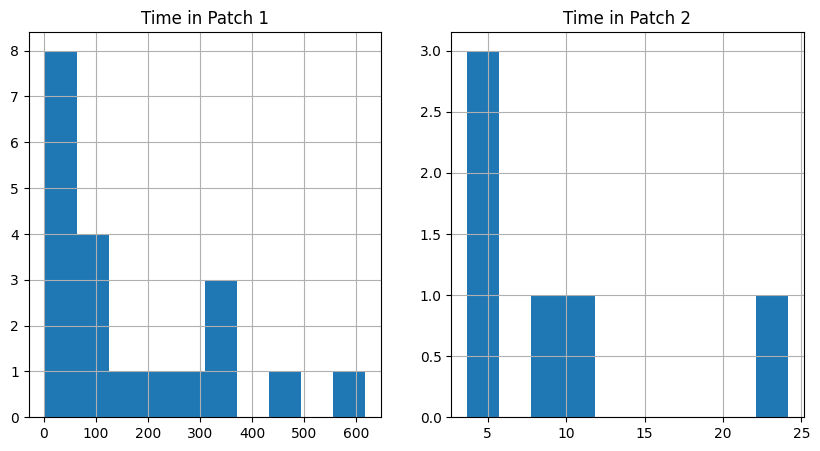

MSE: 23936.81341850942, R-squared: 0.1938142930523825
MSE: 1.4945758142925047, R-squared: 0.9692240799861486


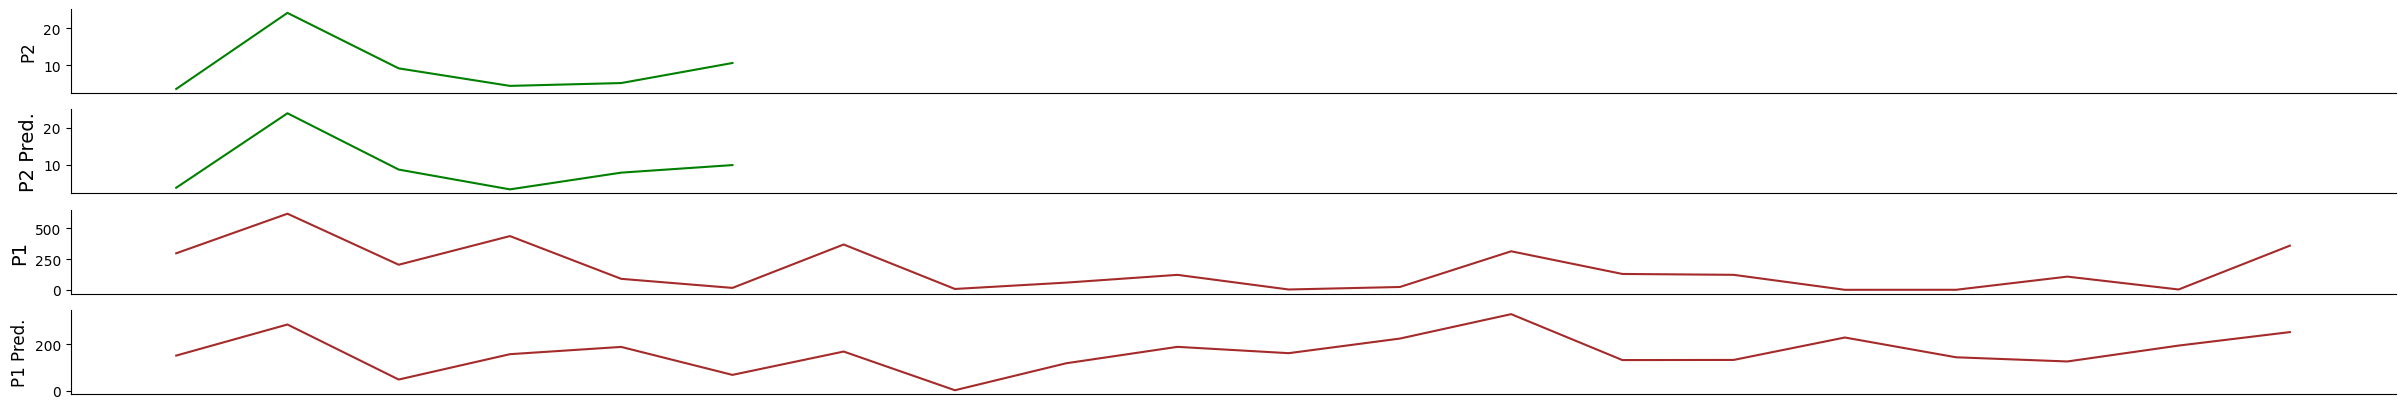

ShortSession11


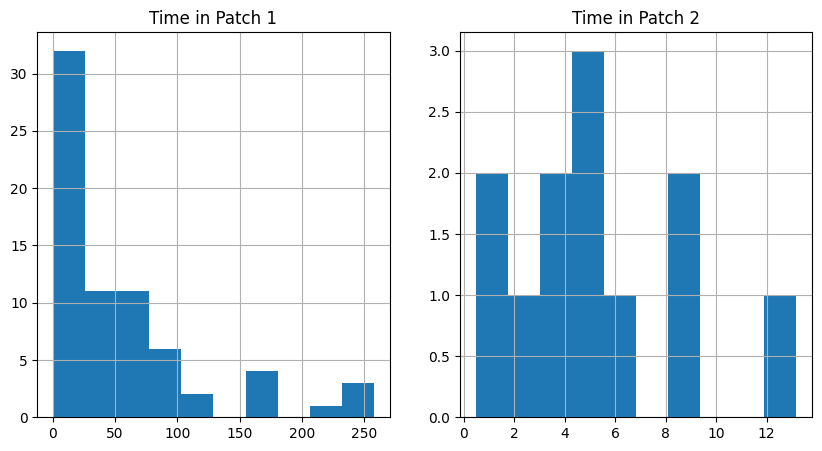

MSE: 2903.2378124992483, R-squared: 0.26198583219883
MSE: 8.367635464467556, R-squared: 0.3041654638251269


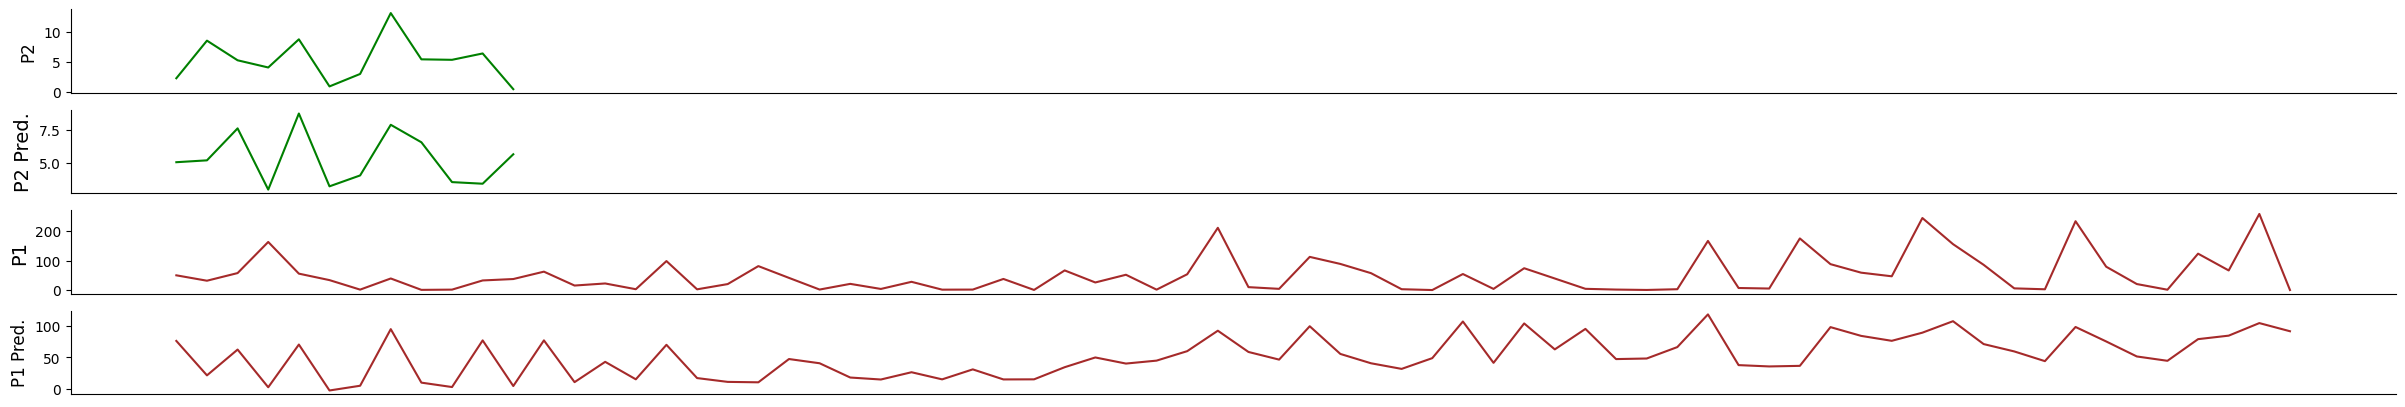

In [8]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
        
    fig, axs = plt.subplots(1,2,figsize = (10,5))
    Visits_Patch1.duration.hist(ax = axs[0])
    Visits_Patch2.duration.hist(ax = axs[1])
    axs[0].set_title('Time in Patch 1')
    axs[1].set_title('Time in Patch 2')
    plt.show()
        
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    
    coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X1, y1)
    print(f"MSE: {mse1}, R-squared: {r21}")
        
    coefficients2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X2, y2)
    print(f"MSE: {mse2}, R-squared: {r22}")
        
    patch.ComparePrediction(y1, y1_pred, y2, y2_pred)
    
    np.savez(title + 'Regression.npz', 
             coefficients_1 = coefficients1, intercept_1 = intercept1, y1_pred = y1_pred, mse_1 = mse1, r2_1 = r21, 
             coefficients_2 = coefficients2, intercept_2 = intercept2, y2_pred = y2_pred, mse_2 = mse2, r2_2 = r22 )

## Coefficients

ShortSession0
ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


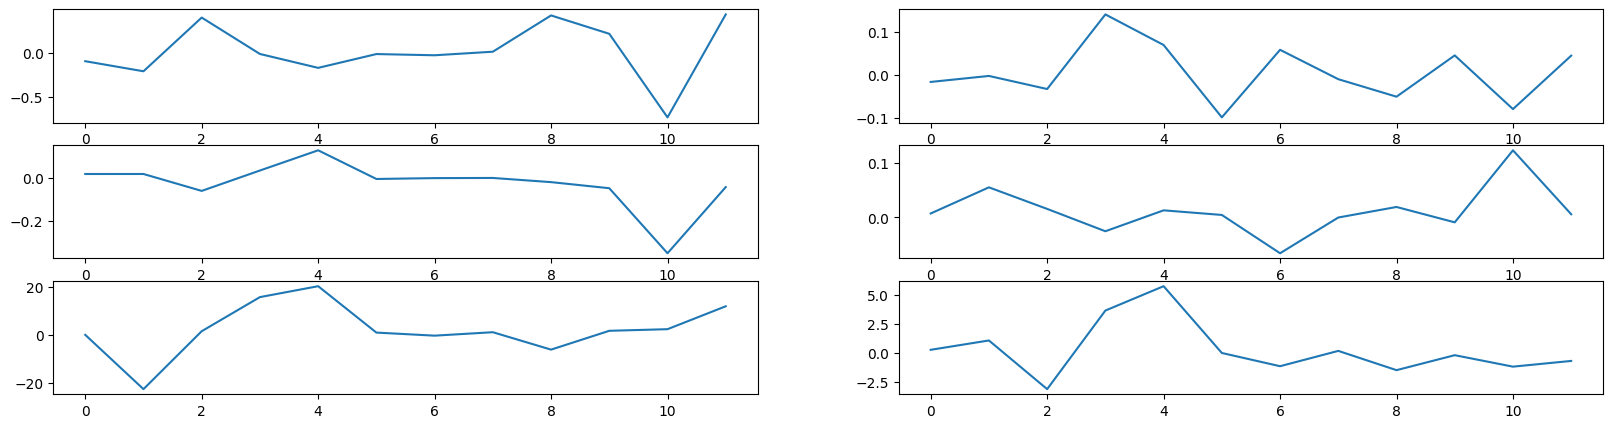

In [27]:
coefficients_patch1 = []
coefficients_patch2 = []
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
    data = np.load(title + 'Regression.npz',allow_pickle=True)
    coefficients_1, coefficients_2= data['coefficients_1'], data['coefficients_2']
    coefficients_patch1.append(coefficients_1)
    coefficients_patch2.append(coefficients_2)
coefficients_patch1, coefficients_patch2 = np.array(coefficients_patch1), np.array(coefficients_patch2)

fig, axs = plt.subplots(3,2, figsize = (20, 5))
for j in range(len(coefficients_patch1[0])): axs[j,0].plot(coefficients_patch1.T[j])
for j in range(len(coefficients_patch2[0])): axs[j,1].plot(coefficients_patch2.T[j])
#axs[0].set_xticklabels(['V', 'a', 'W'])
#axs[1].set_xticklabels(['V', 'a', 'W'])

plt.show()

In [28]:
for j in range(len(coefficients_patch1[0])): print(np.std(coefficients_patch1.T[j]))
for j in range(len(coefficients_patch2[0])): print(np.std(coefficients_patch2.T[j]))

0.31652162539186823
0.10876329186747387
10.444394218858584
0.06582315717038834
0.04315420047456438
2.2617319347910714


In [28]:
for j in range(len(coefficients_patch1[0])): print(np.std(coefficients_patch1.T[j])/np.mean(coefficients_patch1.T[j]))
for j in range(len(coefficients_patch2[0])): print(np.std(coefficients_patch2.T[j])/np.mean(coefficients_patch2.T[j]))

15.102959772140933
-4.056575118177785
4.624336375336778
11.60890203893954
3.606773583948706
8.653155172151052


## Bayes Validation

In [1]:
import arviz as az

In [41]:
def BayesLinearRegression(X, y, title, patch = 1):
    X = X.values
    y = y.values

    data = np.load(title + 'Regression.npz',allow_pickle=True)
    coefficients, intercept= data['coefficients_'+str(patch)], data['intercept_'+str(patch)]
    
    with pm.Model() as model:
        beta1 = pm.Normal('beta1', mu=coefficients[0], sd=0.01)
        beta2 = pm.Normal('beta2', mu=coefficients[1], sd=0.01)
        beta3 = pm.Normal('beta3', mu=coefficients[2], sd=0.01) 
        sigma = pm.HalfNormal('sigma', sd=1)

        # Define likelihood
        likelihood = pm.Normal('y', mu=intercept + beta1 * X[:,0] + beta2 * X[:,1] + beta3 * X[:,2],
                            sd=sigma, observed=y)

        # Sample from posterior
        trace = pm.sample(1000, return_inferencedata=True)
        
        az.summary(trace)
        #az.plot_trace(trace)
        az.plot_posterior(trace, var_names=['beta1', 'beta2', 'beta3'])
    
    return trace

ShortSession0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta3, beta2, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9829597127958207, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta3, beta2, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.9590183931267867, but should be close to 0.8. Try to increase the number of tuning steps.


ShortSession1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta3, beta2, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8967191848348605, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9389130330680903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029889722759891, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta3, beta2, beta1]


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 3 failed.

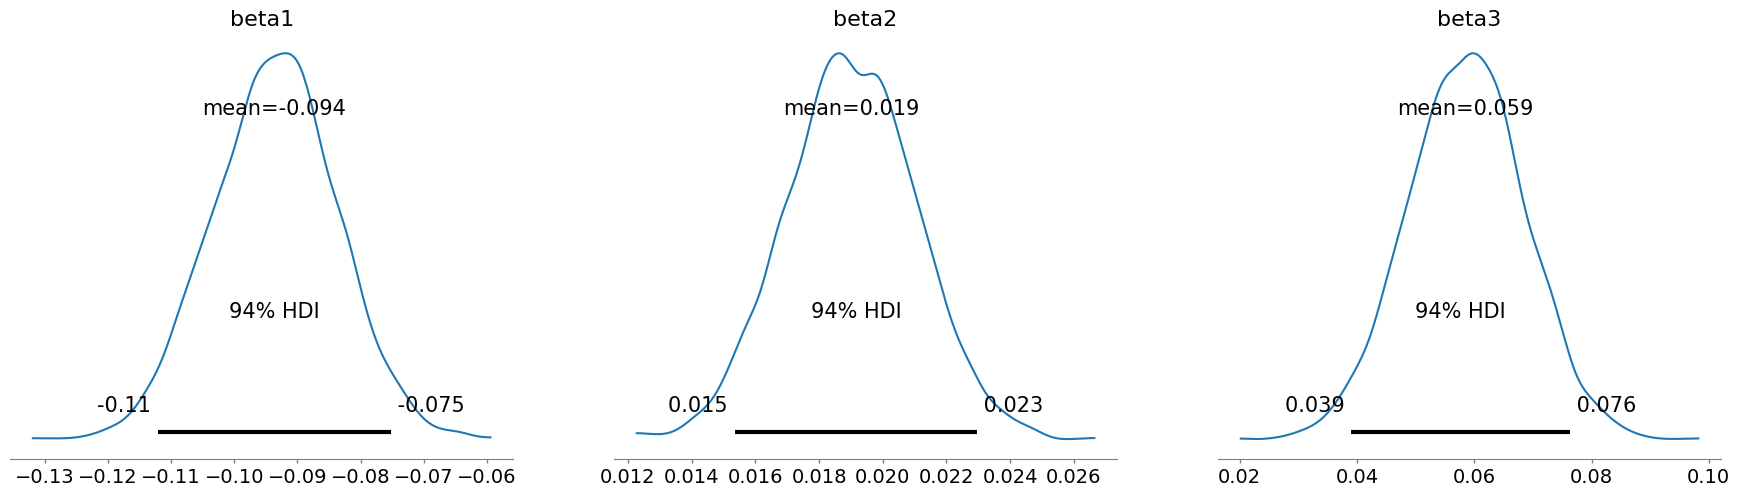

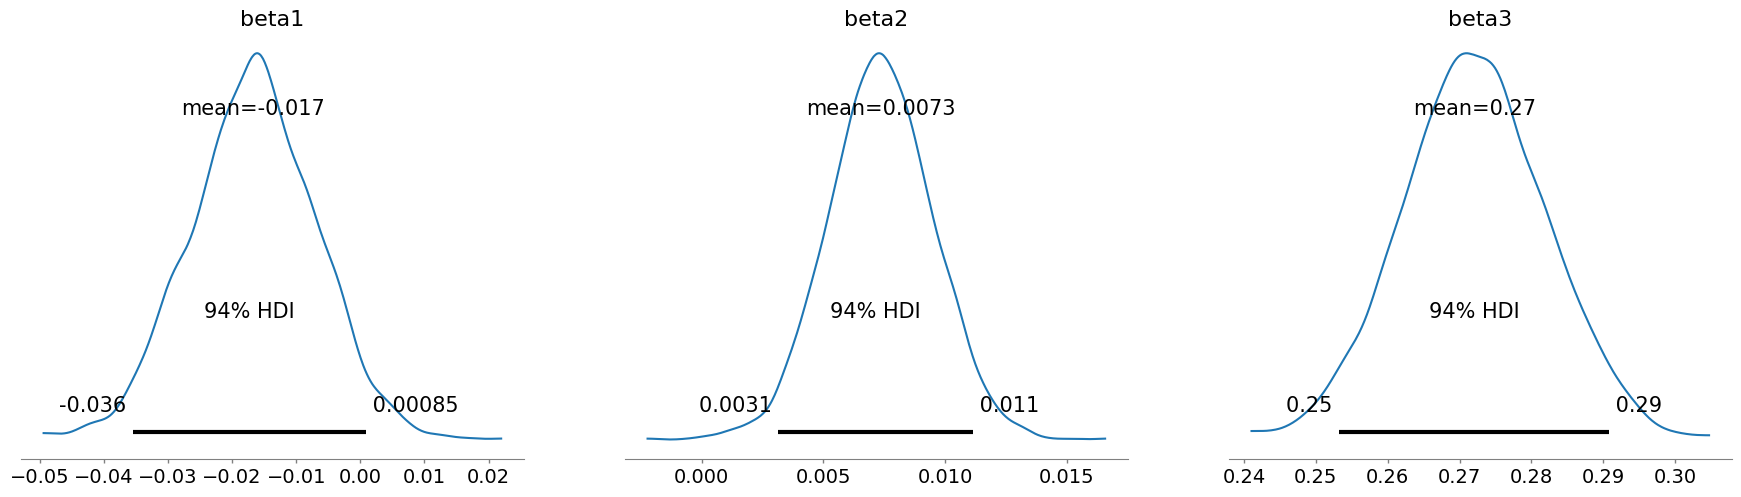

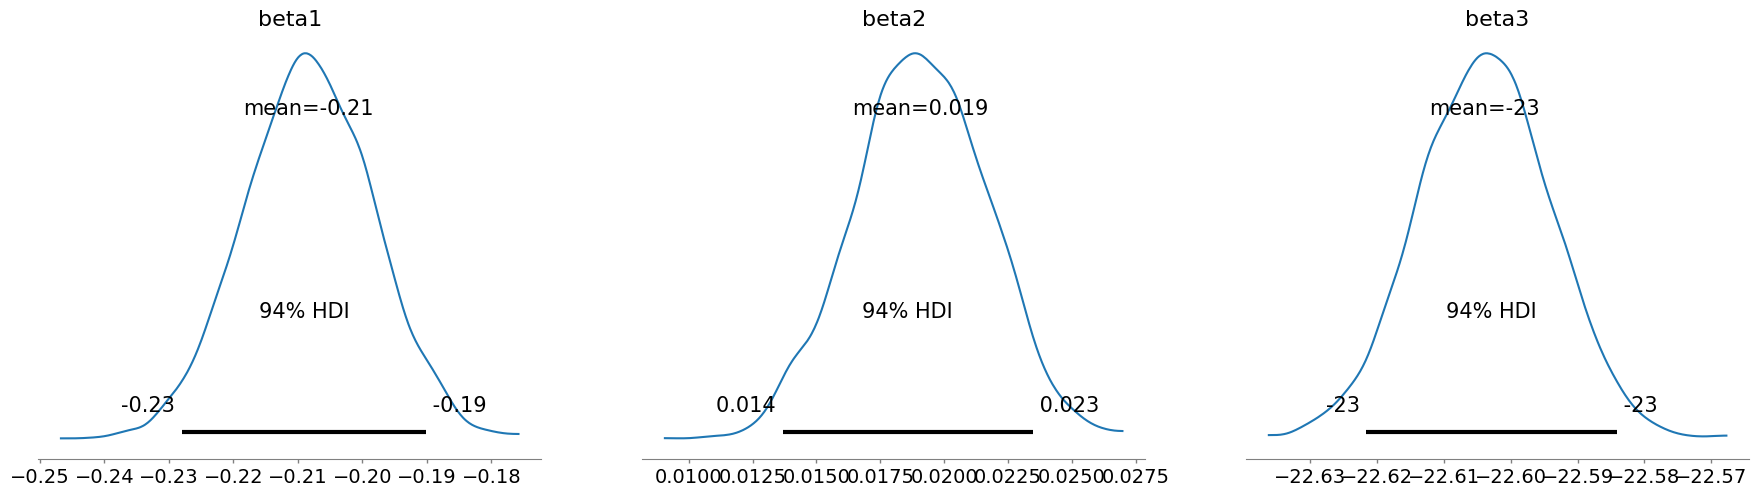

In [42]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
            
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
        
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    BayesLinearRegression(X1, y1, title, patch = 1)
    
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    BayesLinearRegression(X2, y2, title, patch = 2)